# Time Series Analysis of Monterey Airport Weather Data

### Contents

1. Setup
2. Exploring Stationarity
3. Autocorrelation
4. Seasonal Differencing
5. Naive Season-Trend-Level Decomposition
6. Holt-Winters Seasonal Smoothing

### 1. Setup

In [285]:
from datetime import datetime
from random import seed, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [286]:
# pandas settings
pd.set_option('display.max_columns', 125) # csv contains 124 columns
pd.set_option('display.max_rows', 4000) # display more rows
pd.options.mode.chained_assignment = None  # turn off false positive warnings for editing a copy

In [287]:
df = pd.read_csv('cleaned_df.csv', parse_dates=['datetime'], index_col=['datetime'])
df.head()

,DATE,HourlyPresentWeatherType,HourlySkyConditions,HourlyVisibility,HourlyDryBulbTemperature,HourlyWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,HourlyRelativeHumidity,averageObscuration
datetime,,,,,,,,,,,,
2009-04-01 00:08:00,2009-04-01T00:08:00,NaN,"[{'BKN': SkyCondition(obscuration=7, vertical_...",10.0,52.0,8.0,59.0,49.0,26.0,0.0,77.0,7.0
2009-04-01 00:50:00,2009-04-01T00:50:00,NaN,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,52.0,10.0,59.0,49.0,26.0,0.0,77.0,4.0
2009-04-01 00:54:00,2009-04-01T00:54:00,NaN,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,50.0,9.0,59.0,49.0,26.0,0.0,80.0,4.0
2009-04-01 01:54:00,2009-04-01T01:54:00,NaN,[],9.0,51.0,10.0,59.0,49.0,26.0,0.0,77.0,NaN
2009-04-01 02:54:00,2009-04-01T02:54:00,NaN,[],9.0,50.0,16.0,59.0,49.0,26.0,0.0,80.0,NaN


### 2. Exploring Stationarity

We're primarily modeling the daily maximum temperature and daily average obscuration variables.

In [288]:
x = df
bool_index = (x.index.hour >= 10) & (x.index.hour <= 16) # consider the clearest and driest part of each day
x = x[bool_index]

obsc = x['averageObscuration'].resample(rule='D').mean().dropna()
temp = x['DailyMaximumDryBulbTemperature'].resample(rule='D').last().dropna()

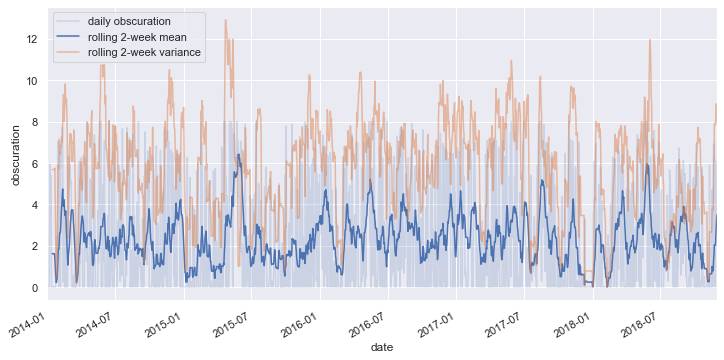

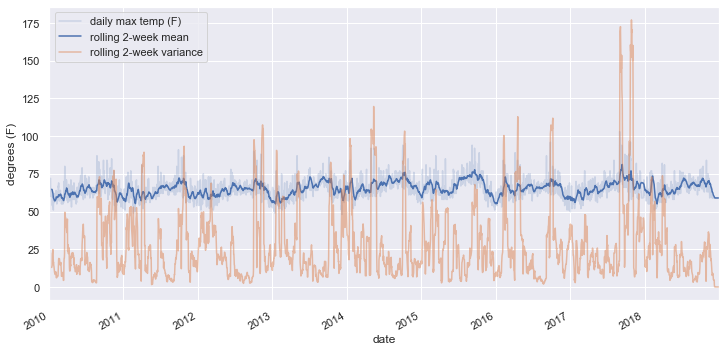

In [257]:
sns.set()



bool_index = (obsc.index.year >= 2014) & (obsc.index.year <= 2018)
obsc = obsc[bool_index]
bool_index = (temp.index.year >= 2010) & (temp.index.year <= 2018)
temp = temp[bool_index]

plt.figure(figsize=(12, 6))
plt.plot(obsc, color='b', alpha=0.2)
obsc.rolling(14).mean().plot()
obsc.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('obscuration')
plt.legend(('daily obscuration', 'rolling 2-week mean', 'rolling 2-week variance'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(temp, color='b', alpha=0.2)
temp.rolling(14).mean().plot()
temp.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('degrees (F)')
plt.legend(('daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))



plt.show()

The series are clearly not stationary: their means and variances are fluctuating all over the place.

Does the Dickey-Fuller test think the daily average obscuration variable acts like a random walk?

In [258]:
results = adfuller(obsc)
print("p-value is:", results[1])

p-value is: 0.0


We can reject the null hypothesis that the daily average obscuration isn't a random walk. We should proceed with modeling.

How about daily maximum temperature?

In [259]:
results = adfuller(temp)
print("p-value is:", results[1])

p-value is: 1.8819053175423097e-06


We can likewise reject the null hypothesis that the Daily Maximum temperature isn't a random walk.

In [260]:
# sanity check: is a random walk a random walk?

# Generate random residuals
np.random.seed(0)
errors = np.random.normal(0, 1, 1000)

# Create AR(1) (random walk) samples for models with and without unit roots
x_unit_root = [0]
x_no_unit_root = [0]
for i in range(len(errors)):
    x_unit_root.append(x_unit_root[-1] + errors[i])
    x_no_unit_root.append(0.9*x_no_unit_root[-1] + errors[i]) # (0.9 isn't 1, so no unit root)

# Calculate Augmented Dickey-Fuller p-values
adfuller(x_unit_root)[1], adfuller(x_no_unit_root)[1] # everything works as expected

(0.8925193132739655, 3.8562004970537815e-06)

### 3. Autocorrelation

The autocorrelation plots of the two variables' difference series will help suggest the types of models that might be appropriate for forecasting the time series.

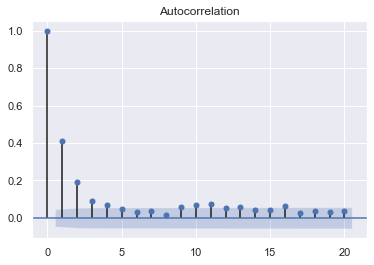

In [262]:
plot_acf(obsc, lags=20)
plt.show()

Lags 1-4 show significant values.

How about the maximum daily temperature series?

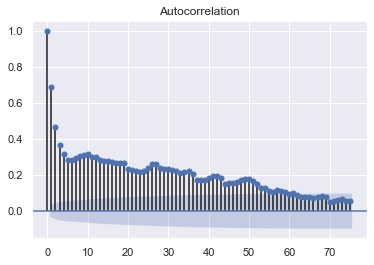

In [263]:
plot_acf(temp, lags=75)
plt.show()

The temperature's autocorrelation plot shows substantial positive and decaying values out to around 70 lags.

### 4. Seasonal Differencing

Does seasonal differencing make the series more stationary?

In [264]:
# annual periods are uneven because of (1) a leap years in 2012 and 2016 and (2) missing data for 2017
for year in range(2010, 2019):
    print('year: ', year, 'length: ', len(temp[temp.index.year == year]))

year:  2010 length:  365
year:  2011 length:  365
year:  2012 length:  366
year:  2013 length:  365
year:  2014 length:  365
year:  2015 length:  365
year:  2016 length:  366
year:  2017 length:  358
year:  2018 length:  365


In [265]:
# discard February 29ths
dates = pd.date_range(start='2010-1-1', end='2018-12-31', freq='D')

leap = []
for each in dates:
    if each.month==2 and each.day ==29:
        leap.append(each)

temp_no_leaps = temp.drop(leap)

In [266]:
# detect missing 2017 data
year_dates = pd.date_range(start='2017-1-1', end='2017-12-31', freq='D')
data_dates = temp[temp.index.year == 2017]
data_dates = data_dates.index
data_dates
missing_timestamps = set(year_dates) - set(data_dates)
missing_timestamps

{Timestamp('2017-12-18 00:00:00', freq='D'),
 Timestamp('2017-12-19 00:00:00', freq='D'),
 Timestamp('2017-12-20 00:00:00', freq='D'),
 Timestamp('2017-12-21 00:00:00', freq='D'),
 Timestamp('2017-12-22 00:00:00', freq='D'),
 Timestamp('2017-12-23 00:00:00', freq='D'),
 Timestamp('2017-12-24 00:00:00', freq='D')}

In [267]:
# repair missing 2017 data by imputing the whole dataset's mean temeparature
mean = np.mean(temp)

x = temp_no_leaps
# x = pd.DataFrame(x)

for missing in missing_timestamps:
    x.loc[missing.to_pydatetime()] = mean
x = x.sort_index()
temp_clean = x

In [268]:
# dealt with uneven annual period
for year in range(2010, 2019):
    print(len(temp_clean[temp_clean.index.year == year]))

365
365
365
365
365
365
365
365
365


In [269]:
temp_diff = temp_clean - temp_clean.shift(365)

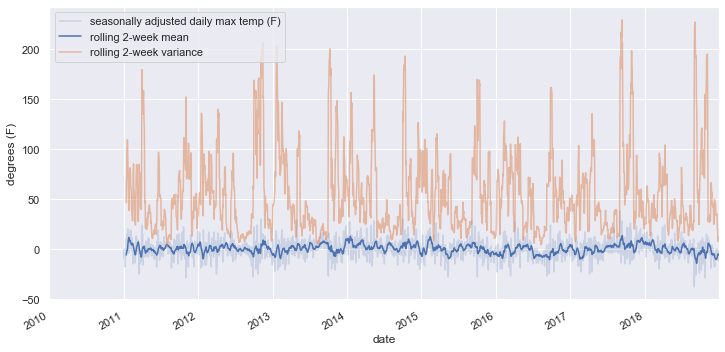

In [270]:
plt.figure(figsize=(12, 6))
plt.plot(temp_diff, color='b', alpha=0.2)
temp_diff.rolling(14).mean().plot()
temp_diff.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('degrees (F)')
plt.legend(('seasonally adjusted daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))
plt.show()

The Dickey-Fuller test shows that seasonal differencing did not make the series stationary.

In [271]:
results = adfuller(temp_diff.dropna())
print("p-value is:", results[1])

p-value is: 1.0873700472681638e-09


### 5. Naive Season-Trend-Level Decomposition

Because the data aren't stationary, it's most appropriate to pursue exponential smoothing, rather than ARIMA approaches. The first approach will use a simple moving average technique.

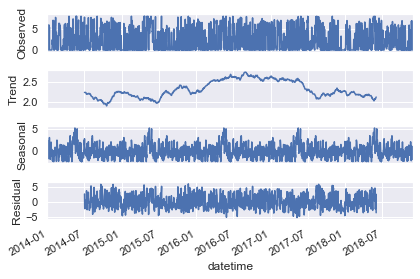

In [272]:
results = seasonal_decompose(obsc, model='additive', freq=365)
results.plot()
plt.show()

This approach identifies a stationary trend but non-stationary seasonal and residual components for both obscuration and max temperature, assuming an annual period.

In [273]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend is stationary

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality isn't

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # nor are residuals

trend df p-value is: 0.6776608029847411
seasonal df p-value is: 3.7688872939552604e-10
residuals p-value is: 0.0


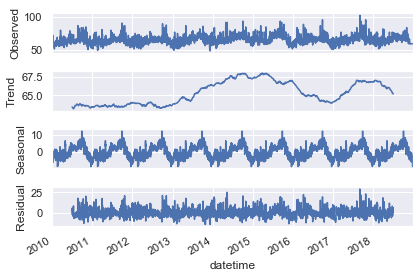

In [274]:
results = seasonal_decompose(temp, model='additive', freq=365)
results.plot()
plt.show()

In [275]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend is stationary

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality isn't

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # nor are residuals

trend df p-value is: 0.5280017871852764
seasonal df p-value is: 0.0001072283921320691
residuals p-value is: 0.0


### 6. Holt-Winters Seasonal Smoothing

Next, we fit a Holt-Winters exponential smoothing model to the temperature data. We will use the Akaike Information Criterion to assess performance.

In [290]:
# separate data into train and test sets
train = temp.iloc[:-365]
test = temp.iloc[-365:]

In [291]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [292]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)
fit3 = model3.fit()
cast3 = fit3.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.

In [293]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - cast3.values)))

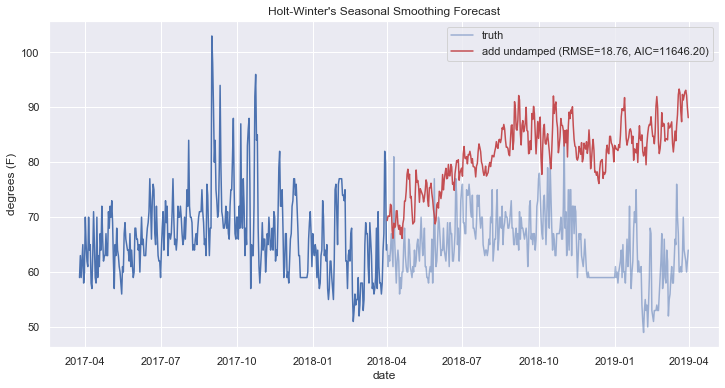

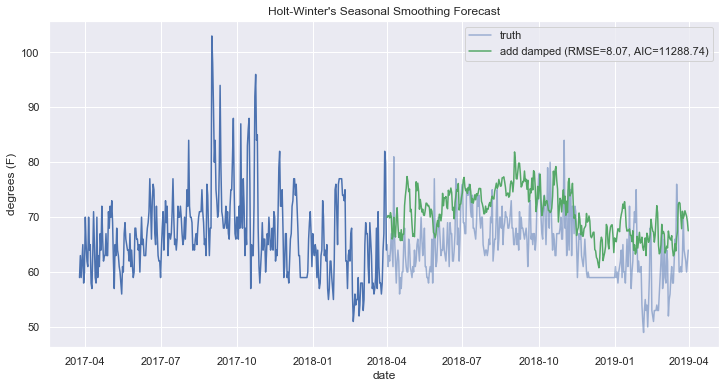

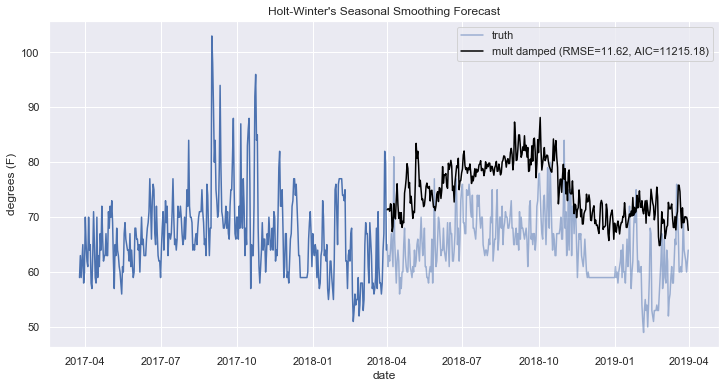

In [294]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast3, color='black', label="mult damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Forecast");
plt.show()

The undamped additive model goes off the rails, and both damped models perform better. [As predicted by Hyndman and Athanasopoulos](https://otexts.com/fpp2/holt-winters.html), the model with damped trend and multiplicative seasonality performs the best by both error and AIC measures.

We repeat the same process for the obscuration data.

In [295]:
# separate data into train and test sets
train = obsc.iloc[:-365]
test = obsc.iloc[-365:]

In [296]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [297]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [298]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))

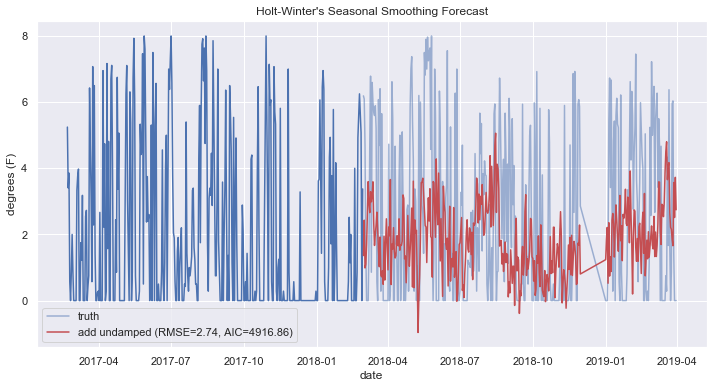

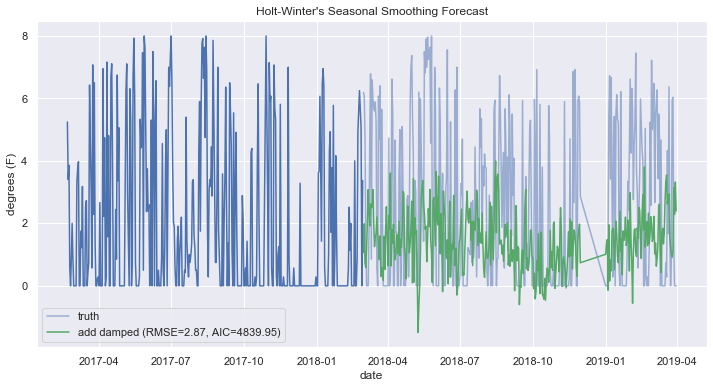

In [299]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Forecast");
plt.show()

For obscuration data, the performance difference between damped and undamped additive models  is much more ambiguous: the undamped model yielded less error, while the damped model yielded a lower AIC score.